In [1]:
!pip install ffmpeg-python
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
import json


import struct

from scipy.io.wavfile import read as wav_read
from scipy import signal, stats
from scipy.signal import chirp, detrend

import io
import ffmpeg

import sounddevice as sd
import matplotlib.pyplot as plt

import time
import numpy as np
from scipy.io import wavfile

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high')
    return filtfilt(b, a, data)

In [5]:
def play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_duration,total_duration,sd):

    sd.default.channels   = 1
    sd.default.samplerate = sample_rate

    chirp_t               = np.linspace(0, chirp_duration, int(sample_rate*chirp_duration))
    chirp_x               = chirp(chirp_t,f0=freq_low,f1=freq_high,t1=chirp_duration,method='linear').astype(np.float32)
    chirps_needed         = int(total_duration / chirp_duration)
    tx                    = np.tile(chirp_x, chirps_needed)
    rx                    = sd.playrec(tx)

    return tx,rx

In [111]:
# sample_rate = 48000
# freq_low    = 17000
# freq_high   = 23000

# chirp_length   = .05
# total_duration = 60   # extend final sound file to "total_duration" seconds

sample_rate = 48000
freq_low = 18000
freq_high = 20000
chirp_length = 0.1       # longer chirp = better freq resolution
total_duration = 60

tx,rx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,total_duration,sd)


In [71]:
tx_sig = tx;
rx_sig = rx[:,0]

num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))

# trim audio to a whole number of chirps recorded
rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]

rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))

time_to_drop = 1
segments_to_drop = int(time_to_drop/chirp_length)
rx_data = rx_data[segments_to_drop:]
tx_data = tx_data[segments_to_drop:]

window_length = rx_data.shape[1]
print(window_length)

### save to json for testing ###
rx_list = rx_data.tolist()
tx_list = tx_data.tolist()

with open("rx_br.json", "w") as f:
    json.dump(rx_list, f)

with open("tx_br.json", "w") as f:
    json.dump(tx_list, f)
### save to json for testing ###

4800


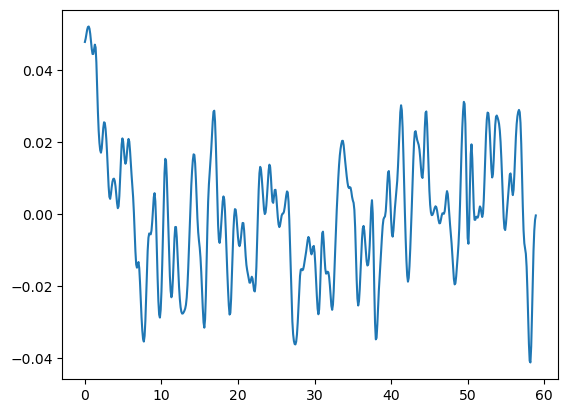

In [97]:
with open("tx_br.json", "r") as f_tx, open("rx_br.json", "r") as f_rx:
    tx_data = json.load(f_tx)
    rx_data = json.load(f_rx)

tx_data = np.array(tx_data)
rx_data = np.array(rx_data)

dechirped = rx_data * np.conj(tx_data)

fft_size = window_length
fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)

bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
phases = np.angle(fft_data[:, bin_to_track])
unwrapped_phases = np.unwrap(phases)
detrended_phase = detrend(unwrapped_phases)

from scipy.ndimage import gaussian_filter1d
detrended_phase = gaussian_filter1d(detrended_phase, sigma=2)
plt.plot(times, smoothed_phase)

# times = np.arange(unwrapped_phases.shape[0]) * chirp_length
# plt.plot(times, detrended_phase)
# plt.xlabel("Time (s)")
# plt.ylabel("Phase (radians)")
# plt.title(f"Phase vs Time at FFT Bin {bin_to_track}")
# plt.grid(True)
# plt.show()

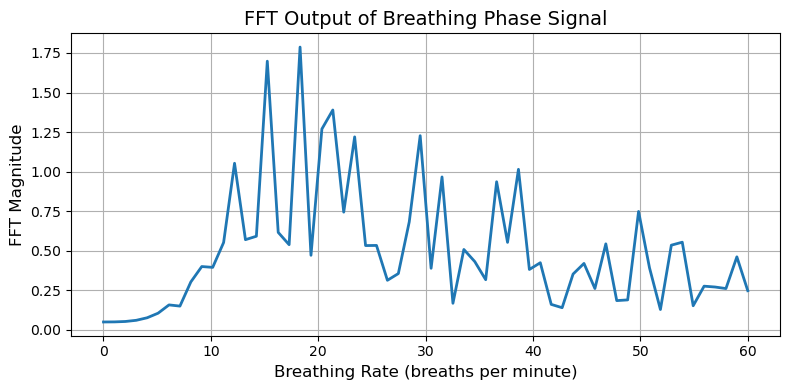

Breathing Rate (initial estimate): 18.31 BPM


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.signal import butter, filtfilt

# -- Step 1: Prepare phase data --
t_start = 0  # in seconds (change this)
chirps_per_second = int(1 / chirp_length)
samples_in_window = 60 * chirps_per_second
start_idx = int(t_start * chirps_per_second)
end_idx = start_idx + samples_in_window

cutoff_bpm = 10
cutoff_hz = cutoff_bpm / 60
fs = 1 / chirp_length  # samples/sec
phase_filtered = highpass(detrended_phase, cutoff=cutoff_hz, fs=fs) 

phase_window = phase_filtered[start_idx:end_idx]

# -- Step 2: Compute FFT --
fft_result = np.fft.fft(phase_window)
fft_magnitude = np.abs(fft_result)
fft_freqs = np.fft.fftfreq(len(phase_window), d=chirp_length)

# -- Step 3: Select positive frequencies within 0-1 Hz (~0-60 BPM) --
positive_freqs = fft_freqs[:len(fft_freqs)//2]
positive_mags = fft_magnitude[:len(fft_magnitude)//2]

# Limit to 0–1 Hz range
bpm_freqs = positive_freqs * 60
mask = (bpm_freqs >= 0) & (bpm_freqs <= 60)
bpm_freqs = bpm_freqs[mask]
positive_mags = positive_mags[mask]

# -- Step 4: Find peak --
peak_index = np.argmax(positive_mags)
peak_bpm = bpm_freqs[peak_index]
peak_mag = positive_mags[peak_index]

# -- Step 5: Plot like Figure 5 --
plt.figure(figsize=(8, 4))
plt.plot(bpm_freqs, positive_mags, linewidth=2)
plt.xlabel("Breathing Rate (breaths per minute)", fontsize=12)
plt.ylabel("FFT Magnitude", fontsize=12)
plt.title("FFT Output of Breathing Phase Signal", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Breathing Rate (initial estimate): {peak_bpm:.2f} BPM")

# print(f"Peak index = {peak_index}")
# print(f"Peak freq (Hz) = {positive_freqs[peak_index]:.4f} Hz")
# print(f"Peak BPM = {positive_freqs[peak_index]*60:.2f} BPM")

# top_k = 10
# sorted_indices = np.argsort(positive_mags)[-top_k:][::-1]
# print("Top frequency peaks:")
# for i in sorted_indices:
#     print(f"Freq: {positive_freqs[i]:.4f} Hz ({positive_freqs[i]*60:.2f} BPM), Mag: {positive_mags[i]:.2f}")

BPM from slope: 7.75, from FFT: 18.31


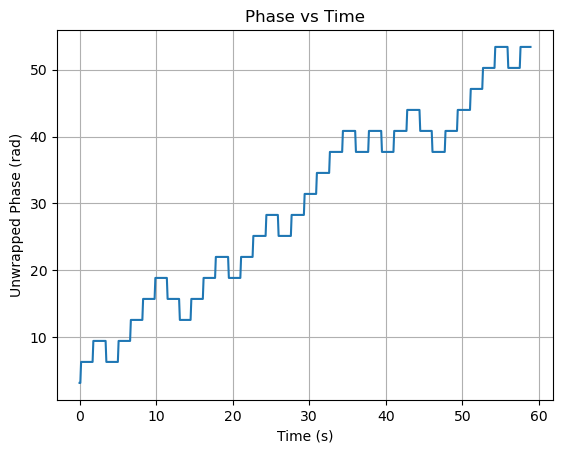

In [115]:
# keep peak and two adjacent bins of FFT
n = len(fft_result)
half_n = n // 2
filtered = np.zeros(n, dtype=complex)

true_peak = np.argmax(np.abs(fft_result[:n//2]))

# store peak and two adjacent bins
for i in [-1, 0, 1]:
    idx = (true_peak + i) % half_n
    filtered[idx] = fft_result[idx]
    filtered[-idx] = np.conj(fft_result[idx])

# perform inverse fft to obtain s'(t)
s_prime = np.fft.ifft(filtered)

# get slope from equation
phase = np.unwrap(np.angle(s_prime))
fs = 1 / chirp_length
time = np.arange(len(phase)) / fs

slope, _, _, _, _ = stats.linregress(time, phase)

bpm = 60 * slope/(2*np.pi)
freq_slope = slope / (2 * np.pi)  # Hz
bpm_slope = freq_slope * 60

freq_fft = fft_freqs[true_peak]
bpm_fft = freq_fft * 60

print(f"BPM from slope: {bpm_slope:.2f}, from FFT: {bpm_fft:.2f}")

plt.plot(time, phase)
plt.title("Phase vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Unwrapped Phase (rad)")
plt.grid()
plt.show()

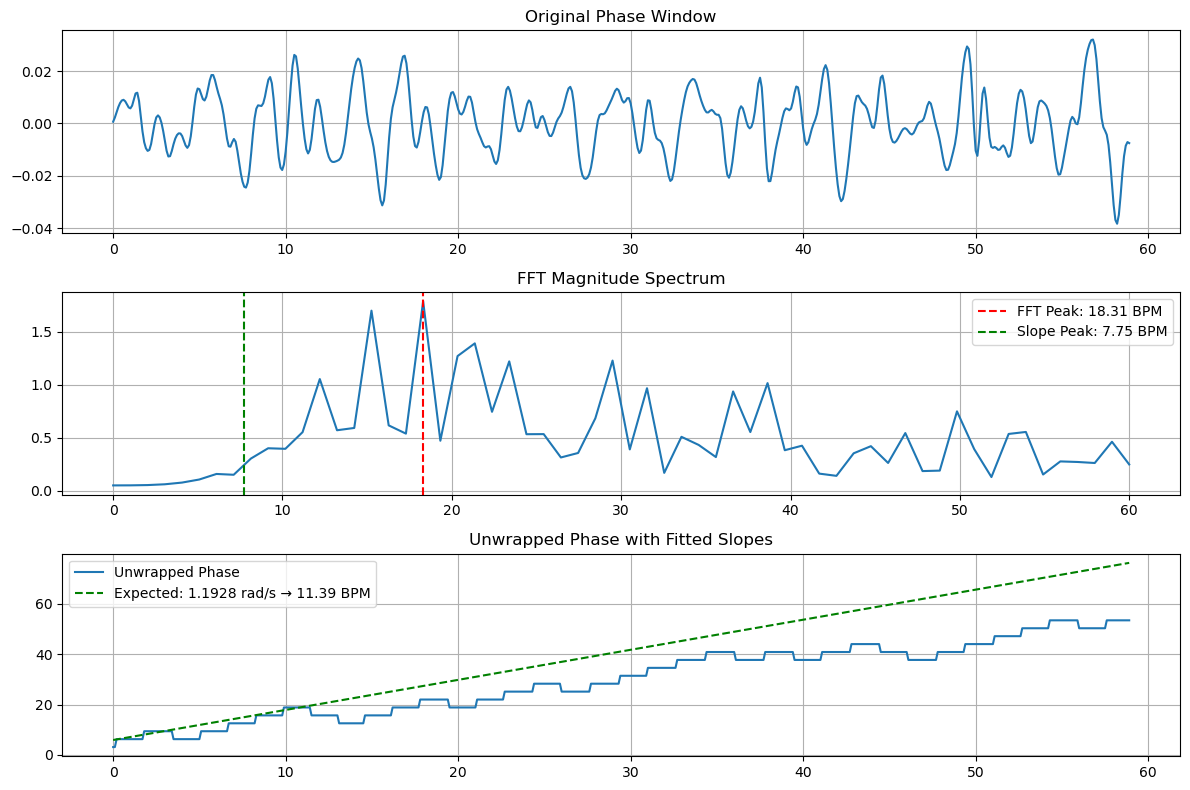

In [113]:
plt.figure(figsize=(12, 8))

# Plot 1: Original phase signal
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(phase_window)) * chirp_length, phase_window)
plt.title("Original Phase Window")
plt.grid(True)

# Plot 2: FFT magnitude spectrum
plt.subplot(3, 1, 2)
plt.plot(bpm_freqs, positive_mags)
plt.axvline(x=bpm_fft, color='r', linestyle='--', 
           label=f'FFT Peak: {bpm_fft:.2f} BPM')
plt.axvline(x=bpm_slope, color='g', linestyle='--', 
           label=f'Slope Peak: {bpm_slope:.2f} BPM')
plt.title("FFT Magnitude Spectrum")
plt.legend()
plt.grid(True)

# Plot 3: Unwrapped phase from narrowband signal
plt.subplot(3, 1, 3)
plt.plot(time, phase, label='Unwrapped Phase')
# Add a reference line with expected slope for 11.39 BPM
expected_slope = (11.39/60) * 2 * np.pi  # Convert BPM to rad/s
plt.plot(time, intercept + expected_slope*time, 'g--', 
         label=f'Expected: {expected_slope:.4f} rad/s → {11.39:.2f} BPM')
plt.title("Unwrapped Phase with Fitted Slopes")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

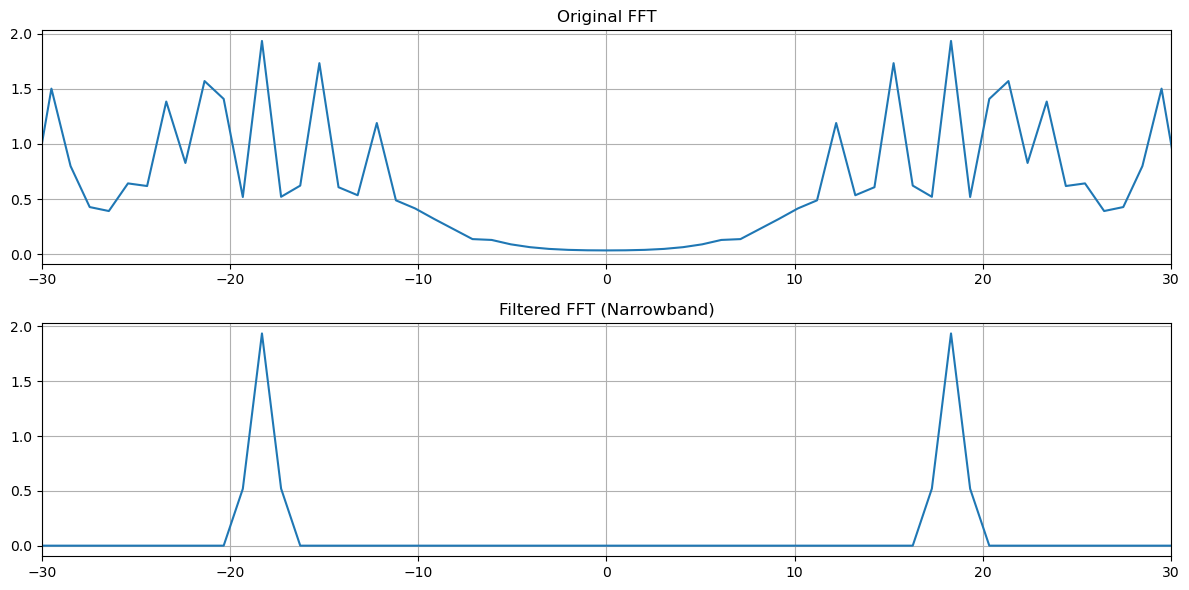

In [91]:
# Plot the FFT before and after narrowband filtering
plt.figure(figsize=(12, 6))

# Original FFT
plt.subplot(2, 1, 1)
plt.plot(np.fft.fftshift(np.fft.fftfreq(n, d=chirp_length)) * 60, 
         np.fft.fftshift(np.abs(fft_result)))
plt.title("Original FFT")
plt.xlim(-30, 30)  # BPM range
plt.grid(True)

# Filtered FFT
plt.subplot(2, 1, 2)
plt.plot(np.fft.fftshift(np.fft.fftfreq(n, d=chirp_length)) * 60, 
         np.fft.fftshift(np.abs(filtered)))
plt.title("Filtered FFT (Narrowband)")
plt.xlim(-30, 30)  # BPM range
plt.grid(True)

plt.tight_layout()
plt.show()